## RQ3: How do various factors influence the predominance of positive or negative evaluations in guest reviews for apartment-type Airbnb accommodations? 

- Sentiment distribution by host type
    - NER
- Sentiment distribution by accomodation type
    - LDA ( Linear discriminant analysis)
    - Topic Modelling
- Sentiment distribution by neighborhood
    - LDA ( Linear discriminant analysis)
    - Topic Modelling


In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
from IPython.display import display, HTML

In [3]:
# Load the listings and reviews data
listings = pd.read_csv('final_apartment_df.csv')
reviews = pd.read_csv('spelling_corrected_reviews.csv')
# Fix the column name
reviews.rename(columns=lambda x: x.strip(), inplace=True)


In [4]:
# Function to clean review text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

reviews['cleaned_review'] = reviews['comments'].apply(clean_text)

In [5]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)

reviews['sentiment'] = reviews['comments'].apply(get_sentiment_score)

# Classify sentiments
def classify_sentiment(sentiment):
    if sentiment['compound'] > 0.05:
        return 'positive'
    elif sentiment['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews['sentiment_class'] = reviews['sentiment'].apply(classify_sentiment)

In [6]:
# Merge dataframes
merged_data = pd.merge(reviews, listings, on='listing_id')


## Mostly common word mention in location related reviews 

- NER > spacy , GPE type

In [7]:
nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

merged_data['entities'] = merged_data['comments'].apply(extract_entities)

In [8]:
# Flatten the list of entities and count occurrences
all_entities = [entity for sublist in merged_data['entities'] for entity in sublist]
entity_counter = Counter([entity[0] for entity in all_entities if entity[1] == 'GPE'])  # Only consider GPE (geopolitical entities)

# Display the most common entities
common_entities = entity_counter.most_common(10)
print(common_entities)

[('kensington', 94), ('netflix', 90), ('richmond', 52), ('us', 48), ('liverpool', 34), ('anna', 27), ('paddington', 24), ('finsbury park', 24), ('india', 23), ('twickenham', 23)]


('anna', 27) - host name

In [9]:
# Extract reviews containing 'anna'
anna_reviews = merged_data[merged_data['comments'].str.contains('anna', case=False, na=False)]

# Display a sample of the reviews containing 'anna'
anna_sample = anna_reviews[['comments']].sample(10)
print(anna_sample.to_string(index=False))

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              comments
                                                                                                                                                                                                                                                                                                                                                                 

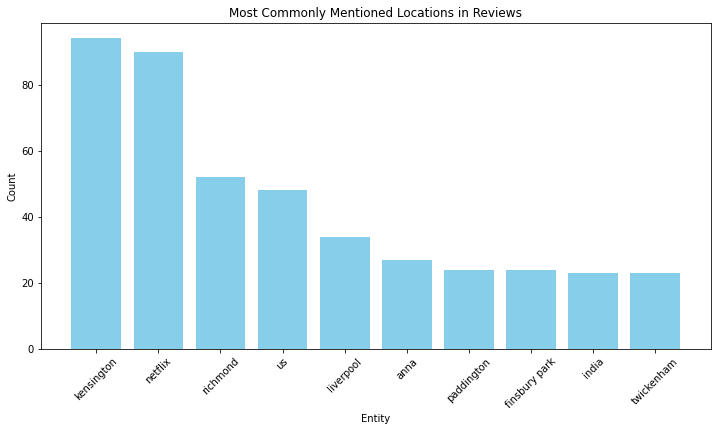

In [10]:
# Convert common entities to DataFrame for visualization
entity_df = pd.DataFrame(common_entities, columns=['Entity', 'Count'])

# Plot the most common entities
plt.figure(figsize=(12, 6))
plt.bar(entity_df['Entity'], entity_df['Count'], color='skyblue')
plt.title('Most Commonly Mentioned Locations in Reviews')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Apply customise lexicon dictionary 

#### VADER Sentiment Analysis
VADER is a lexicon and rule-based sentiment analysis tool specifically designed to analyze sentiments expressed in social media contexts. It computes a sentiment score by analyzing the input text and provides four scores:

- Positive: The proportion of text that is positive.
- Negative: The proportion of text that is negative.
- Neutral: The proportion of text that is neutral.
- Compound: A normalized, weighted composite score that ranges from -1 (most extreme negative) to +1 (most extreme positive).

#### Compound Score

The compound score is a single metric that calculates the overall sentiment of a text by combining the positive, negative, and neutral scores. It is a normalized score that lies between -1 and +1, where:

+1 represents the most positive sentiment.
-1 represents the most negative sentiment.

#### Why These Thresholds?
- Balance:

The thresholds of 0.05 and -0.05 are chosen to ensure that only texts with a clear positive or negative inclination are classified as such.
Texts with a compound score close to zero are likely to contain mixed or ambiguous sentiments, which are best classified as neutral.

Reference: https://www.researchgate.net/publication/350761338_A_Review_on_Lexicon-Based_and_Machine_Learning_Political_Sentiment_Analysis_Using_Tweets

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


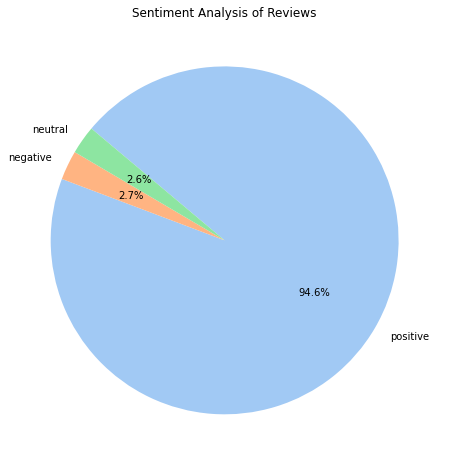

  Sentiment  Count
0  positive  31388
1  negative    905
2   neutral    876


In [11]:
import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Load the dataset
language_reviews_path = 'spelling_corrected_reviews.csv'
language_custom_2 = pd.read_csv(language_reviews_path)

# Fix the column name
language_custom_2.rename(columns=lambda x: x.strip(), inplace=True)

# Function to clean text and remove stop words
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

# Apply text cleaning
language_custom_2['processed_comments'] = language_custom_2['comments'].apply(clean_text)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to classify comments as positive, negative, or neutral using VADER
def classify_sentiment_vader(text):
    score = sid.polarity_scores(text)
    if score['compound'] > 0.05:
        return 'positive'
    elif score['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment analysis to the reviews DataFrame
language_custom_2['sentiment'] = language_custom_2['processed_comments'].apply(classify_sentiment_vader)

# Count how many reviews are positive, negative, and neutral
sentiment_counts = language_custom_2['sentiment'].value_counts()

# Plot pie chart with pastel colors
pastel_colors = sns.color_palette('pastel')
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=pastel_colors, counterclock=False)
plt.title('Sentiment Analysis of Reviews')
plt.show()

# Create summary DataFrame
summary_df = sentiment_counts.reset_index()
summary_df.columns = ['Sentiment', 'Count']

# Print the summary DataFrame
print(summary_df)


# 1. Sentiment Analysis #
## Sentiment Distribution by Host Type ##

The bar chart visualizes the distribution of sentiments (positive, negative, neutral) across different host types (normal hosts and super hosts).

Higher bars indicate a greater number of reviews.
Compare the heights of bars within the same sentiment category to see if one host type (host or super_host) consistently receives more positive, negative, or neutral reviews.

Identify Patterns:

If super hosts have a higher proportion of positive reviews, it suggests that guests tend to have a better experience with super hosts.
Conversely, if normal hosts have more negative reviews, it might indicate areas for improvement.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


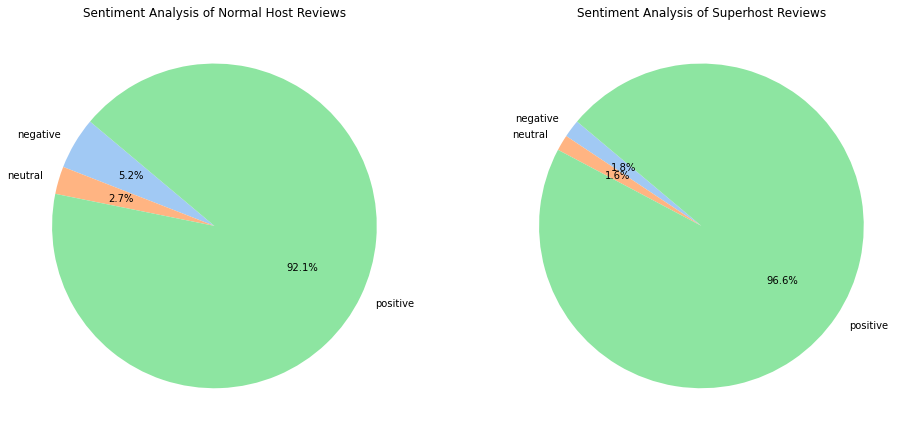

sentiment_class  negative  neutral  positive
host_type                                   
Normal Host          1215      643     21525
Superhost             174      154      9458


In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import re
import warnings
from spacy import displacy
from IPython.display import display, HTML

# Download VADER lexicon
nltk.download('vader_lexicon')

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Load the listings and reviews data
listings_2 = pd.read_csv('final_apartment_df.csv')
reviews_2 = pd.read_csv('spelling_corrected_reviews.csv')

# Fix the column name
reviews_2.rename(columns=lambda x: x.strip(), inplace=True)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to get sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)

# Apply the sentiment analysis to the reviews DataFrame
reviews_2['sentiment'] = reviews_2['comments'].apply(get_sentiment_score)

# Classify sentiments
def classify_sentiment(sentiment):
    if sentiment['compound'] > 0.05:
        return 'positive'
    elif sentiment['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews_2['sentiment_class'] = reviews_2['sentiment'].apply(classify_sentiment)

# Function to clean text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    return text

# Apply text cleaning
reviews_2['cleaned_comments'] = reviews_2['comments'].apply(clean_text)

# Apply NER to identify host mentions
def extract_hosts(text):
    doc = nlp(text)
    hosts = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    return hosts

reviews_2['hosts'] = reviews_2['cleaned_comments'].apply(extract_hosts)

# Ensure matching data types for merging
reviews_2['listing_id'] = reviews_2['listing_id'].astype(str)
listings_2['listing_id'] = listings_2['listing_id'].astype(str)

# Merge dataframes
merged_data = pd.merge(reviews_2, listings_2, on='listing_id')

# Identify host type (Superhost or normal host)
merged_data['host_type'] = merged_data['host_is_superhost'].apply(lambda x: 'Superhost' if x == 't' else 'Normal Host')

# Group data by host type and sentiment class
host_sentiments = merged_data.groupby(['host_type', 'sentiment_class']).size().unstack().fillna(0)

# Plot pie charts for each host type with pastel colors
pastel_colors = sns.color_palette('pastel')
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for ax, (host_type, counts) in zip(axs, host_sentiments.iterrows()):
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=pastel_colors)
    ax.set_title(f'Sentiment Analysis of {host_type} Reviews')

plt.show()

# Create summary DataFrame
summary_df = merged_data.groupby(['host_type', 'sentiment_class']).size().unstack().fillna(0)
print(summary_df)


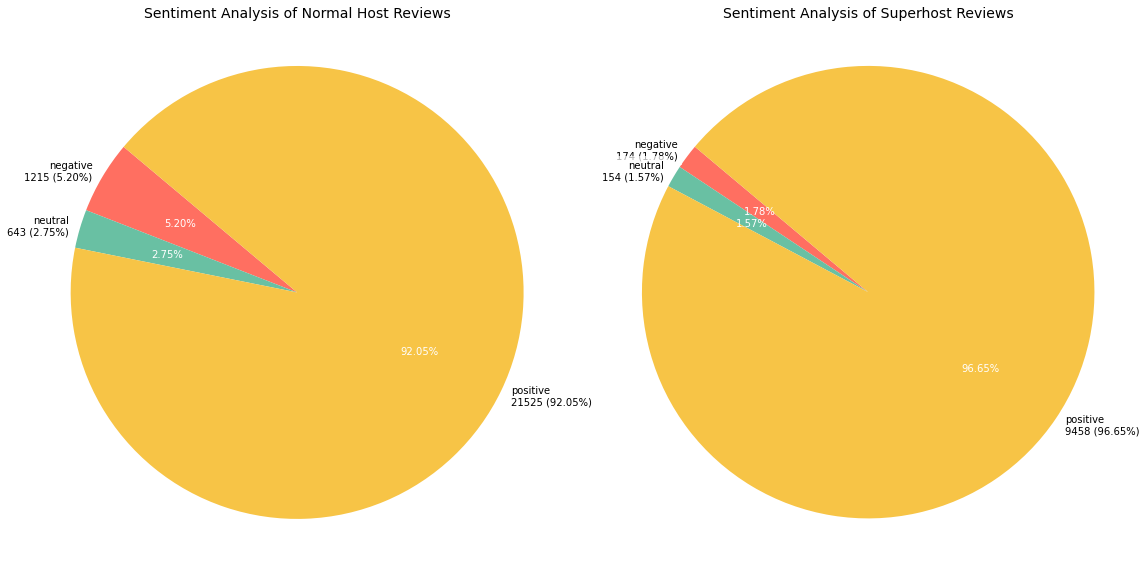

In [34]:
# Define a custom pastel color palette: pastel red, green, and blue
pastel_colors = ['#ff6f61', '#69c0a3', '#f7c446']  # Coral, Pastel Green, Light Yellow

# Plot pie charts for each host type with pastel colors and detailed labels
fig, axs = plt.subplots(1, 2, figsize=(16, 8))  # Create subplots for each host type

for ax, (host_type, counts) in zip(axs, host_sentiments.iterrows()):
    total = counts.sum()  # Total number of reviews for each host type
    
    # Define labels with counts and percentages
    labels = [f"{sentiment}\n{count} ({percentage:.2f}%)" 
              for sentiment, count, percentage in zip(counts.index, counts, 100 * counts / total)]
    
    # Plot pie chart with custom colors and improved label positioning
    wedges, texts, autotexts = ax.pie(
        counts, 
        labels=labels, 
        autopct='%1.2f%%',  # Display only percentages inside the chart
        startangle=140, 
        colors=pastel_colors, 
        labeldistance=1.05  # Adjust distance for labels outside
    )
    
    # Customize text size and format
    for text in texts:
        text.set_fontsize(10)
        text.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='none'))
        
    for autotext in autotexts:
        autotext.set_fontsize(10)
        autotext.set_color('white')
    
    ax.set_title(f'Sentiment Analysis of {host_type} Reviews', fontsize=14)  # Set title for each chart
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()  # Adjust subplots to fit in figure area.
plt.show()  # Display the plots


#### Defintion

**Host** is anyone who lists their property (or a room within their property) on the platform for guests to book.

**Superhost** a host who has consistently provided exceptional hospitality and met specific criteria set by Airbnb.

- Completed at least 10 trips or 3 reservations that total at least 100 nights: This shows they have a good track record of hosting guests.
- Maintained a 90% response rate or higher: This indicates they are responsive to inquiries and concerns.
- Maintained a less than 1% cancellation rate: This demonstrates reliability and commitment to hosting.
- Maintained a 4.8 overall rating: This reflects high guest satisfaction with their hosting experience.

(Airbnb,n.d.)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


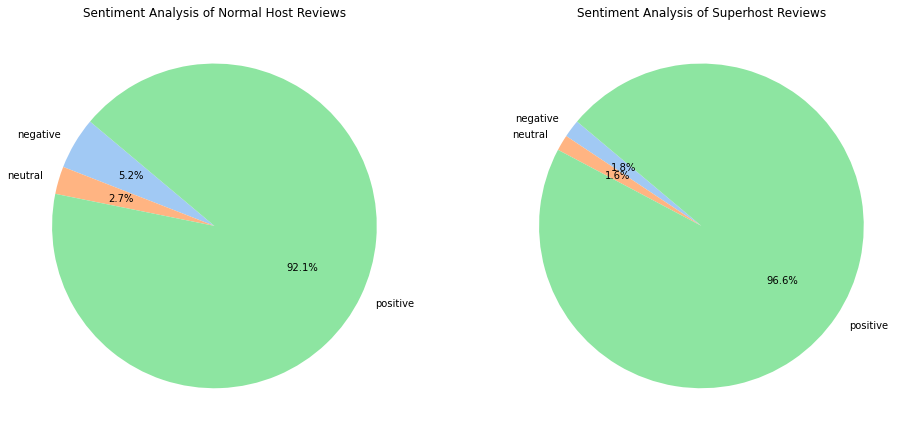

sentiment_class  negative  neutral  positive
host_type                                   
Normal Host          1215      643     21525
Superhost             174      154      9458


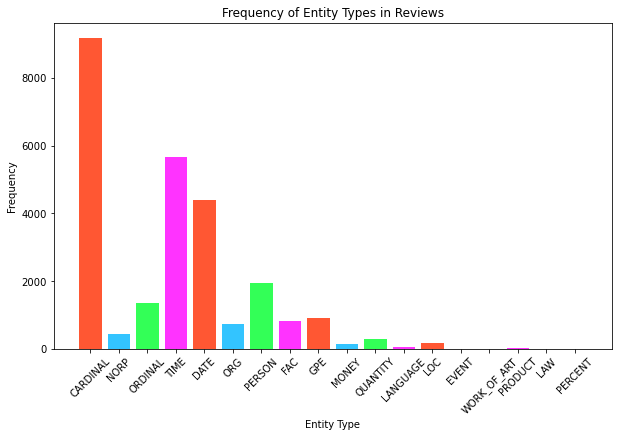

In [56]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from spacy import displacy
from IPython.display import display, HTML

# Download VADER lexicon
nltk.download('vader_lexicon')

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Load the listings and reviews data
listings_2 = pd.read_csv('final_apartment_df.csv')
reviews_2 = pd.read_csv('spelling_corrected_reviews.csv')

# Fix the column name
reviews_2.rename(columns=lambda x: x.strip(), inplace=True)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to get sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)

# Apply the sentiment analysis to the reviews DataFrame
reviews_2['sentiment'] = reviews_2['comments'].apply(get_sentiment_score)

# Classify sentiments
def classify_sentiment(sentiment):
    if sentiment['compound'] > 0.05:
        return 'positive'
    elif sentiment['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews_2['sentiment_class'] = reviews_2['sentiment'].apply(classify_sentiment)

# Function to clean text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    return text

# Apply text cleaning
reviews_2['cleaned_comments'] = reviews_2['comments'].apply(clean_text)

# Apply NER to identify host mentions
def extract_hosts(text):
    doc = nlp(text)
    hosts = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    return hosts

reviews_2['hosts'] = reviews_2['cleaned_comments'].apply(extract_hosts)

# Ensure matching data types for merging
reviews_2['listing_id'] = reviews_2['listing_id'].astype(str)
listings_2['listing_id'] = listings_2['listing_id'].astype(str)

# Merge dataframes
merged_data = pd.merge(reviews_2, listings_2, on='listing_id')

# Identify host type (Superhost or normal host)
merged_data['host_type'] = merged_data['host_is_superhost'].apply(lambda x: 'Superhost' if x == 't' else 'Normal Host')

# Group data by host type and sentiment class
host_sentiments = merged_data.groupby(['host_type', 'sentiment_class']).size().unstack().fillna(0)

# Plot pie charts for each host type with pastel colors
pastel_colors = sns.color_palette('pastel')
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for ax, (host_type, counts) in zip(axs, host_sentiments.iterrows()):
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=pastel_colors)
    ax.set_title(f'Sentiment Analysis of {host_type} Reviews')

plt.show()

# Create summary DataFrame
summary_df = merged_data.groupby(['host_type', 'sentiment_class']).size().unstack().fillna(0)
print(summary_df)

from collections import Counter

# Collect all entities from reviews
all_entities = []
for text in reviews_2['comments']:
    doc = nlp(text)
    all_entities.extend([(ent.text, ent.label_) for ent in doc.ents])

# Count occurrences of each entity type
entity_counter = Counter([ent[1] for ent in all_entities])

# Create a bar chart of entity types
plt.figure(figsize=(10, 6))
plt.bar(entity_counter.keys(), entity_counter.values(), color=['#FF5733', '#33C4FF', '#33FF57', '#FF33FF'])
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.title('Frequency of Entity Types in Reviews')
plt.xticks(rotation=45)
plt.show()


**Overall Interpretation:**

**Positive Review Dominance:** The overwhelming number of positive reviews for both hosts and super hosts indicates high guest satisfaction. The higher number of positive reviews for normal hosts could be due to a larger number of listings or more reviews overall.

**Super Hosts vs. Hosts:** Super hosts, despite having fewer total reviews, show a better ratio of positive to negative reviews compared to normal hosts. This suggests that super hosts are more likely to deliver consistently high-quality experiences.

**Negative Reviews:** The presence of negative reviews, though smaller in number, indicates areas where hosts and super hosts can improve. Super hosts having fewer negative reviews suggests they may be more responsive or proactive in addressing guest concerns.

**Actionable Insights:**

**For Hosts:**

Aim to understand and replicate the factors contributing to positive reviews.
Address the issues leading to negative reviews to improve overall ratings.

**For Super Hosts:**

Continue maintaining high standards to minimize negative reviews.
Use positive feedback to reinforce successful practices and enhance guest experiences.

**For Airbnb Platform:**

Provide resources and training for normal hosts to help them achieve super host status.
Encourage sharing of best practices among hosts to improve service quality across the platform.

## Sentiment by Type of Accommodation ##

-LDA ( Linear discriminant analysis)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 0: room apartment bed would bit bathroom one small night kitchen
Topic 1: great stay place location would clean recommend host apartment definitely
Topic 2: station close walk london tube restaurants minutes easy great apartment
Topic 3: good well apartment clean accommodation nice location stay located comfortable
Topic 4: us host airing time check stay even checking made one


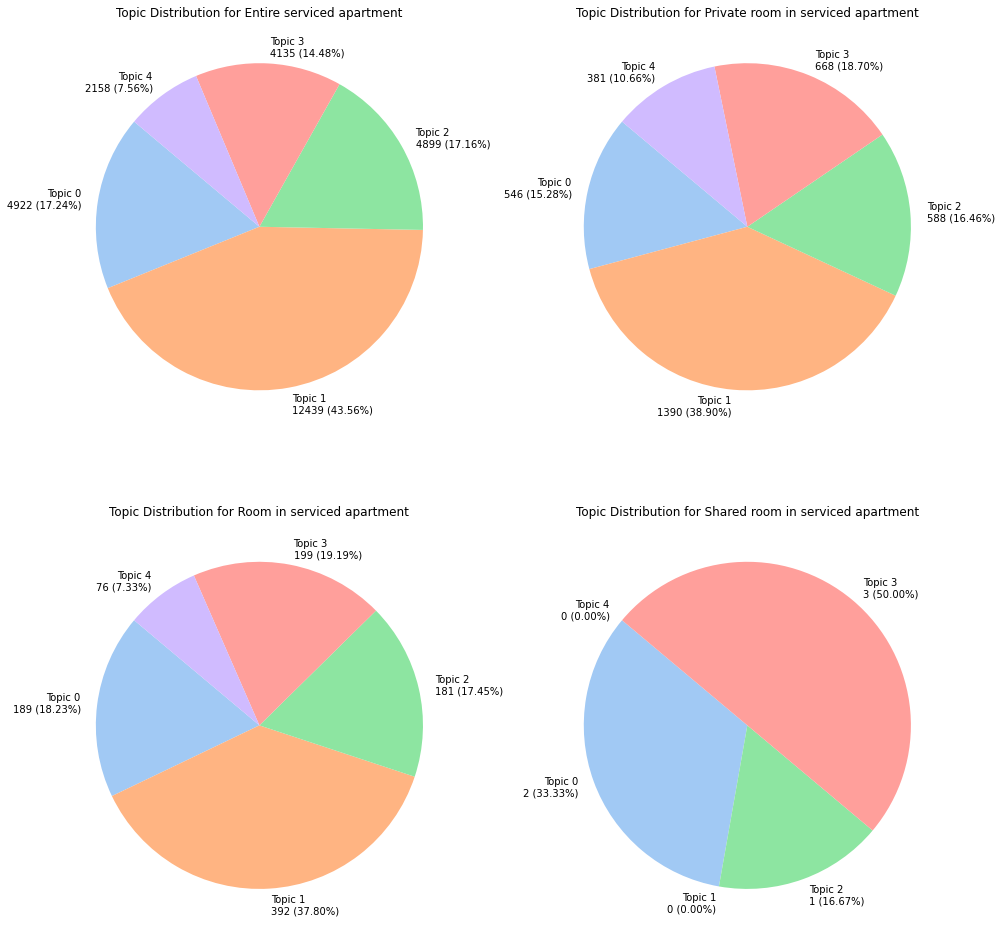

topic                                    0        1       2       3       4
property_type                                                              
Entire serviced apartment           4922.0  12439.0  4899.0  4135.0  2158.0
Private room in serviced apartment   546.0   1390.0   588.0   668.0   381.0
Room in serviced apartment           189.0    392.0   181.0   199.0    76.0
Shared room in serviced apartment      2.0      0.0     1.0     3.0     0.0


In [52]:
import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from gensim.models.phrases import Phrases, Phraser

# Download necessary NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Load the listings and reviews data
listings_3 = pd.read_csv('final_apartment_df.csv')
reviews_3 = pd.read_csv('spelling_corrected_reviews.csv')

# Fix the column name
reviews_3.rename(columns=lambda x: x.strip(), inplace=True)

# Define additional stop words
custom_stopwords = set(stopwords.words('english') + ['the', 'and', 'a', 'to', 'of', 'is', 'in', 'for', 'it'])

# Function to clean text and replace 'onion' with 'london'
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    text = re.sub(r'\bonion\b', 'london', text)  # Replace 'onion' with 'london'
    return text

# Apply text cleaning
reviews_3['cleaned_comments'] = reviews_3['comments'].apply(clean_text)

# Tokenize and remove stop words
def tokenize_and_remove_stopwords(text):
    tokens = [word for word in text.split() if word not in custom_stopwords]
    return tokens

reviews_3['tokens'] = reviews_3['cleaned_comments'].apply(tokenize_and_remove_stopwords)

# Use bigrams and trigrams
bigram = Phrases(reviews_3['tokens'], min_count=5, threshold=100)
trigram = Phrases(bigram[reviews_3['tokens']], threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

reviews_3['bigrams'] = make_bigrams(reviews_3['tokens'])
reviews_3['trigrams'] = make_trigrams(reviews_3['tokens'])

# Use trigrams for topic modeling
tokenized_docs = reviews_3['trigrams']

# Create a dictionary representation of the documents
dictionary = Dictionary(tokenized_docs)

# Filter extremes
dictionary.filter_extremes(no_below=10, no_above=0.5)

# Create a corpus from the dictionary representation
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# Fit LDA model to identify latent topics
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=20, random_state=0)

# Display the top words for each topic
def display_topics(model, num_topics, num_words):
    topics = []
    for topic_idx, topic in model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
        topic_words = " ".join([word for word, _ in topic])
        topics.append(f"Topic {topic_idx}: {topic_words}")
    return topics

# Display topics
topics = display_topics(lda_model, num_topics=5, num_words=10)
for topic in topics:
    print(topic)

# Merge dataframes
reviews_3['listing_id'] = reviews_3['listing_id'].astype(str)
listings_3['listing_id'] = listings_3['listing_id'].astype(str)
merged_data = pd.merge(reviews_3, listings_3, on='listing_id')

# Assign the dominant topic to each review
merged_data['topic'] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]

# Group data by property type and topic
accommodation_topics = merged_data.groupby(['property_type', 'topic']).size().unstack().fillna(0)

# Plot pie charts for topic distribution by type of accommodation
property_types = accommodation_topics.index
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

for ax, property_type in zip(axes, property_types):
    data = accommodation_topics.loc[property_type]
    total_reviews = data.sum()
    percentages = (data / total_reviews) * 100
    labels = [f"Topic {topic}\n{count:.0f} ({percentage:.2f}%)"
              for topic, count, percentage in zip(data.index, data, percentages)]
    ax.pie(data, labels=labels, autopct='', startangle=140, colors=sns.color_palette('pastel'))
    ax.set_title(f'Topic Distribution for {property_type}')

plt.tight_layout()
plt.show()

# Create summary DataFrame for topic counts by property type
topic_counts = merged_data.groupby('property_type')['topic'].value_counts().unstack().fillna(0)
print(topic_counts)

# Visualize Topics using pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)


## Topic Interpretation

**Topic 0: room apartment bed would bit bathroom one small night kitchen**

**Interpretation:** This topic likely focuses on the specific features and layout of the apartment or room, highlighting aspects like the size of the bed, bathroom, and kitchen. The presence of words like "small" and "bit" might suggest comments about the space being compact or cozy. This can provide insights into how guests perceive the apartment's physical characteristics.

**Topic 1: great stay place location would clean recommend host apartment definitely**

**Interpretation:** This topic emphasizes positive guest experiences, with a focus on the location, cleanliness, and the host's hospitality. Words like "recommend" and "definitely" suggest high satisfaction, indicating that these are key factors contributing to positive reviews. This can guide property owners on what to maintain or improve to ensure positive feedback.

**Topic 2: station close walk london tube restaurants minutes easy great apartment**

**Interpretation:** This topic centers around the property's proximity to public transportation and amenities. Words like "station," "walk," "tube," and "restaurants" highlight the convenience of the location, which is a crucial factor for guests looking for accessible accommodation. This topic can help identify properties that are popular for their strategic location.

**Topic 3: good well apartment clean accommodation nice location stay located comfortable**

**Interpretation:** Similar to Topic 1, this topic focuses on the general quality of the accommodation. However, it appears more balanced with emphasis on "comfortable" and "nice," suggesting overall satisfaction with the living conditions. This reinforces the importance of cleanliness and comfort in guest experiences.

**Topic 4: us host airing time check stay even checking made one**

**Interpretation:** This topic seems to focus on the interaction between guests and the host, specifically around check-in and check-out experiences. The words "airing," "time," "check," and "made" suggest logistics and personal interactions, potentially indicating that guests value smooth and efficient check-in/check-out processes and the host's efforts to accommodate them.

In [6]:
# Assign topics to each review
merged_data['topic'] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]

# Extract reviews associated with Topic 2
topic_2_reviews = merged_data[merged_data['topic'] == 2]

# Filter reviews containing the word 'onion'
onion_reviews = topic_2_reviews[topic_2_reviews['cleaned_comments'].str.contains('onion', case=False, na=False)]

# Display a sample of these reviews to analyze the context
onion_sample = onion_reviews[['cleaned_comments']].sample(10, random_state=1)
print(onion_sample.to_string(index=False))

## Sentiment by Neighbourhood ##
Objective: Apply NER and Topic Modelling to analyze sentiments for different neighbourhoods.

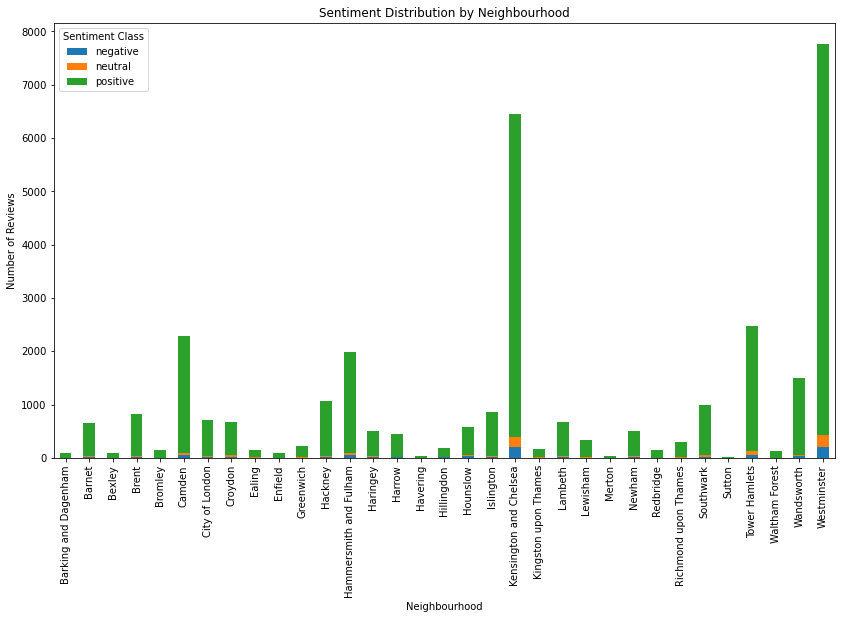

In [14]:
# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to get sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)

# Apply the sentiment analysis to the reviews DataFrame
reviews['sentiment'] = reviews['cleaned_review'].apply(get_sentiment_score)

# Classify sentiments
def classify_sentiment(sentiment):
    if sentiment['compound'] > 0.05:
        return 'positive'
    elif sentiment['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews['sentiment_class'] = reviews['sentiment'].apply(classify_sentiment)

# Ensure matching data types for merging
reviews['listing_id'] = reviews['listing_id'].astype(str)
listings['listing_id'] = listings['listing_id'].astype(str)

# Merge dataframes
merged_data = pd.merge(reviews, listings, on='listing_id')

# Group data by neighbourhood_cleansed and sentiment class
neighbourhood_sentiments = merged_data.groupby(['neighbourhood_cleansed', 'sentiment_class']).size().unstack().fillna(0)

# Plot the data
neighbourhood_sentiments.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Sentiment Distribution by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment Class')
plt.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Topic 0: london street located restaurants area home famous central west just
Topic 1: walk london minutes away street station park minute restaurants road
Topic 2: provided london kensington area famous royal south road city shopping
Topic 3: london area street city located shopping restaurants residential world wharf
Topic 4: london kensington lots park west area famous restaurants spaces transport


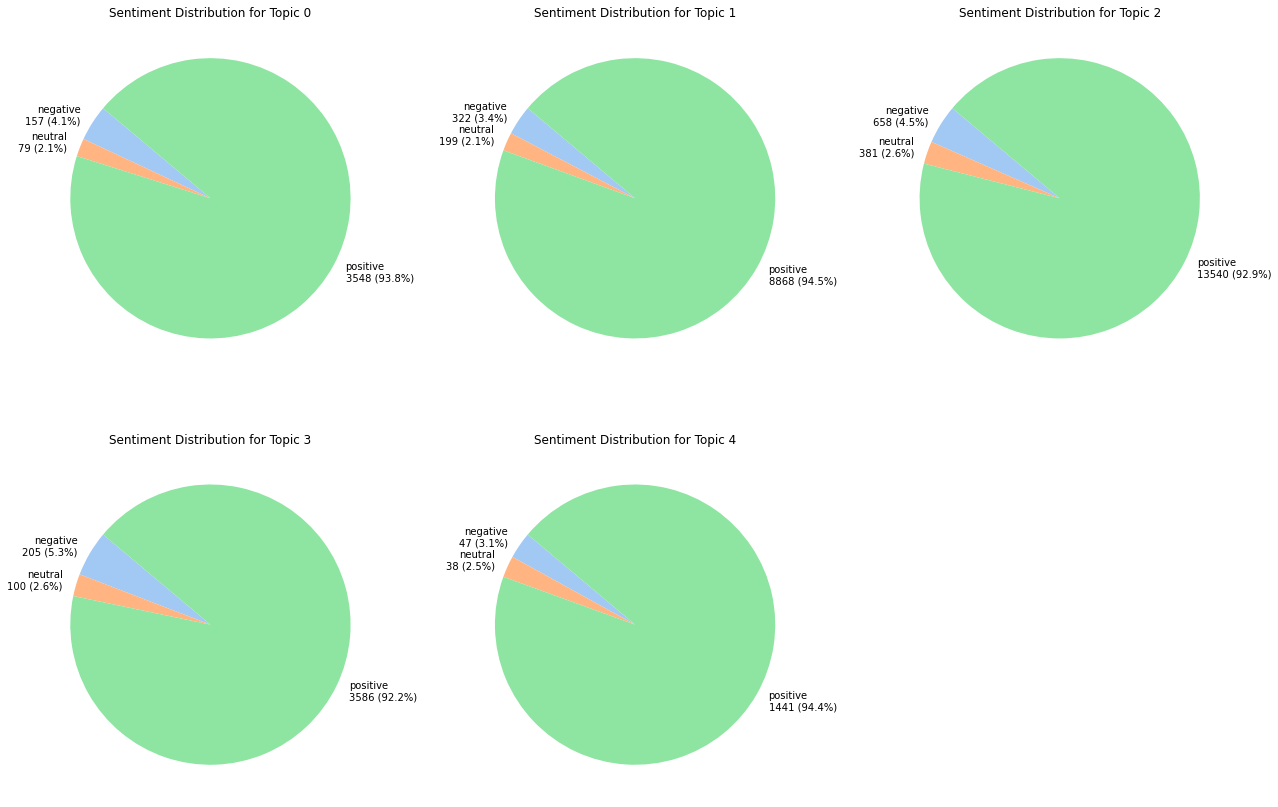

sentiment_class  negative  neutral  positive
topic                                       
0                     157       79      3548
1                     322      199      8868
2                     658      381     13540
3                     205      100      3586
4                      47       38      1441


In [51]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import re

# Download VADER lexicon
nltk.download('vader_lexicon')

# Load the listings and reviews data
listings_1 = pd.read_csv('final_apartment_df.csv')
reviews_1 = pd.read_csv('spelling_corrected_reviews.csv')

# Fix the column name
reviews_1.rename(columns=lambda x: x.strip(), inplace=True)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to get sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)

# Apply the sentiment analysis to the reviews DataFrame
reviews_1['sentiment'] = reviews_1['comments'].apply(get_sentiment_score)

# Classify sentiments
def classify_sentiment(sentiment):
    if sentiment['compound'] > 0.05:
        return 'positive'
    elif sentiment['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews_1['sentiment_class'] = reviews_1['sentiment'].apply(classify_sentiment)

# Ensure matching data types for merging
reviews_1['listing_id'] = reviews_1['listing_id'].astype(str)
listings_1['listing_id'] = listings_1['listing_id'].astype(str)

# Merge dataframes
merged_data = pd.merge(reviews_1, listings_1, on='listing_id')

# Clean 'neighborhood_overview' to remove 'br' and other HTML-like tags
listings_1['neighborhood_overview'] = listings_1['neighborhood_overview'].fillna('').apply(
    lambda x: re.sub(r'\bbr\b', '', x.lower()))  # Removes 'br'

# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
neighbourhood_overview_matrix = vectorizer.fit_transform(listings_1['neighborhood_overview'])

# Apply LDA to extract topics
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(neighbourhood_overview_matrix)

# Display the topics
def display_topics(model, feature_names, num_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics.append(topic_words)
        print(f"Topic {topic_idx}: {' '.join(topic_words)}")
    return topics

num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, feature_names, num_top_words)

# Merge LDA topics with neighbourhoods
topics_matrix = lda.transform(neighbourhood_overview_matrix)
listings_1['topic'] = topics_matrix.argmax(axis=1)

# Merge topic data with merged_data
merged_data = pd.merge(merged_data, listings_1[['listing_id', 'topic']], on='listing_id')

# Group data by topic and sentiment class
topic_sentiments = merged_data.groupby(['topic', 'sentiment_class']).size().unstack().fillna(0)

# Plot pie charts for each topic
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i in range(5):
    ax = axes[i]
    data = topic_sentiments.loc[i]
    
    # Create labels with both count and percentage
    total = data.sum()
    labels = [f"{sentiment}\n{count} ({percentage:.1f}%)" 
              for sentiment, count, percentage in zip(data.index, data, 100 * data / total)]
    
    ax.pie(data, labels=labels, startangle=140, colors=sns.color_palette('pastel'))
    ax.set_title(f'Sentiment Distribution for Topic {i}')

# Remove the empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

# Create summary DataFrame for topic counts by sentiment
topic_counts = merged_data.groupby('topic')['sentiment_class'].value_counts().unstack().fillna(0)
print(topic_counts)

# Visualize Topics using pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)



#### Insights from the Topics


**Topic 0: london street located restaurants area home famous central west just**
- Interpretation: This topic centres around properties located in well-known areas of London, emphasising their central location and proximity to restaurants. It suggests a sense of prestige or fame associated with these neighbourhoods.

**Topic 1: walk london minutes away street station park minute restaurants road**
- Interpretation: This topic emphasises the walkability and convenience of neighbourhoods, highlighting easy access to parks, restaurants, and public transportation.


**Topic 2: provided london kensington area famous royal south road city shopping**
- Interpretation: This topic highlights upscale neighbourhoods, especially Kensington, known for its royal associations and shopping options.



**Topic 3: london area street city located shopping restaurants residential world wharf**
- Interpretation: This topic revolves around urban residential areas that offer shopping, dining, and potentially waterfront views (e.g., Canary Wharf).

**Topic 4: london kensington lots park west area famous restaurants spaces transport**
- Interpretation: This topic discusses areas with abundant green spaces and transport options, particularly in West London, such as Kensington.

#### Actionable Recommendations

**1. Marketing Strategies:**

- **Topic 0 (Prestigious Locations and Dining):**

    - Highlight the Appeal: Emphasize the prestige of living in central, famous areas with excellent dining options.
    - Customer Testimonials: Use testimonials that highlight the allure of being located in sought-after neighborhoods.

- **Topic 1 (Walkability and Convenience):**

    - Promote Accessibility: Market the neighborhoods as highly walkable, with easy access to parks and public transport.
    - Local Experiences: Create marketing campaigns focused on experiencing the city on foot, promoting nearby parks and cafes.

- **Topic 2 (Upscale and Royal Neighborhoods):**

    - Focus on Luxury: Highlight the royal heritage and shopping opportunities in areas like Kensington.
    - Collaborations: Partner with luxury brands and shops for exclusive promotions and events.

- **Topic 3 (Urban Residential Appeal):**

    - Vibrant Lifestyle: Emphasize the mix of residential comfort and city amenities, appealing to young professionals and families.
    - Community Events: Promote community events and social gatherings to highlight the neighborhood's residential appeal.

- **Topic 4 (Green Spaces and Transport):**

    - Promote Outdoor Activities: Market the proximity to parks and green spaces as a key selling point.
    - Convenient Commuting: Highlight transport links that make commuting easy and convenient for residents.

**2. Trip Planning:**

**Personalized Recommendations:**

    - Use sentiment analysis to recommend neighborhoods that align with customer preferences, such as walkability or proximity to shopping.

**Themed Itineraries:**

- **Topic 0: Prestigious Dining Experiences**
    - Itinerary: "Central Dining Delights" - Explore famous restaurants and enjoy the vibrant lifestyle in London's central areas.

- **Topic 1: Walkability and Convenience**
    - Itinerary: "Explore on Foot" - Enjoy the ease of walking to parks, cafes, and nearby attractions.

- **Topic 2: Upscale Shopping and Royal Heritage**
    - Itinerary: "Luxury Shopping Spree" - Discover high-end shopping and explore the royal heritage of Kensington.

- **Topic 3: Urban Residential Experience**
    - Itinerary: "City Living and Waterfronts" - Experience urban living with shopping and waterfront views in places like Canary Wharf.

- **Topic 4: Green Spaces and Transport**
    - Itinerary: "Green Retreats" - Enjoy abundant parks and convenient transport links in West London.

In [44]:
# Topic Modelling by Neighbourhood
neighbourhoods = merged_data['neighbourhood_cleansed'].unique()

for neighbourhood in neighbourhoods:
    neighbourhood_reviews = merged_data[merged_data['neighbourhood_cleansed'] == neighbourhood]['comments']
    text_data = neighbourhood_reviews.apply(lambda x: x.split())
    
    # Check if text_data is not empty
    if text_data.empty or all(len(x) == 0 for x in text_data):
        print(f"No sufficient data for topic modeling in neighbourhood: {neighbourhood}")
        continue
    
    # Create dictionary and corpus
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    
    # Build LDA model
    if len(dictionary) == 0:
        print(f"No terms found for neighbourhood: {neighbourhood}")
        continue
    
    lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)
    
    # Print topics for the neighbourhood
    print(f'Topics for Neighbourhood: {neighbourhood}')
    for idx, topic in lda_model.print_topics(-1):
        print(f'Topic: {idx} \nWords: {topic}\n')
    
# Visualize Topics using pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)
    
    

Topics for Neighbourhood: Hammersmith and Fulham
Topic: 0 
Words: 0.039*"the" + 0.036*"to" + 0.029*"and" + 0.028*"is" + 0.025*"a" + 0.020*"i" + 0.016*"place" + 0.015*"it" + 0.013*"was" + 0.012*"for"

Topic: 1 
Words: 0.048*"i" + 0.013*"great" + 0.008*"location" + 0.006*"place" + 0.006*"no" + 0.005*"amazing" + 0.005*"comment" + 0.004*"you" + 0.003*"to" + 0.003*"for"

Topic: 2 
Words: 0.059*"and" + 0.042*"the" + 0.031*"was" + 0.028*"a" + 0.027*"to" + 0.026*"very" + 0.017*"stay" + 0.015*"in" + 0.015*"we" + 0.015*"for"

Topic: 3 
Words: 0.045*"and" + 0.041*"the" + 0.039*"a" + 0.032*"to" + 0.020*"in" + 0.018*"is" + 0.017*"was" + 0.016*"great" + 0.014*"with" + 0.014*"for"

Topic: 4 
Words: 0.077*"the" + 0.031*"and" + 0.027*"to" + 0.022*"was" + 0.020*"is" + 0.019*"a" + 0.017*"in" + 0.014*"i" + 0.014*"of" + 0.013*"it"

Topics for Neighbourhood: Richmond upon Thames
Topic: 0 
Words: 0.061*"the" + 0.040*"and" + 0.029*"a" + 0.025*"to" + 0.024*"was" + 0.021*"in" + 0.017*"for" + 0.017*"is" + 0.016*

Topics for Neighbourhood: Southwark
Topic: 0 
Words: 0.016*"and" + 0.012*"apartment" + 0.010*"great" + 0.010*"lovely" + 0.010*"a" + 0.008*"location" + 0.006*"beds" + 0.006*"accommodation" + 0.006*"in" + 0.005*"clean"

Topic: 1 
Words: 0.064*"the" + 0.045*"and" + 0.033*"was" + 0.027*"to" + 0.023*"a" + 0.015*"it" + 0.015*"very" + 0.015*"we" + 0.014*"is" + 0.013*"of"

Topic: 2 
Words: 0.068*"the" + 0.035*"and" + 0.028*"a" + 0.023*"is" + 0.021*"in" + 0.019*"to" + 0.019*"very" + 0.012*"apartment" + 0.012*"with" + 0.012*"was"

Topic: 3 
Words: 0.050*"the" + 0.041*"and" + 0.032*"a" + 0.027*"to" + 0.017*"was" + 0.016*"of" + 0.015*"is" + 0.015*"in" + 0.012*"with" + 0.012*"onion"

Topic: 4 
Words: 0.044*"and" + 0.035*"to" + 0.031*"the" + 0.030*"a" + 0.025*"great" + 0.025*"was" + 0.023*"stay" + 0.017*"for" + 0.016*"in" + 0.016*"location"

Topics for Neighbourhood: Haringey
Topic: 0 
Words: 0.081*"the" + 0.040*"and" + 0.030*"is" + 0.024*"to" + 0.023*"a" + 0.020*"was" + 0.015*"very" + 0.013*"in" + 

Topics for Neighbourhood: Harrow
Topic: 0 
Words: 0.057*"and" + 0.034*"the" + 0.029*"to" + 0.026*"was" + 0.017*"a" + 0.016*"in" + 0.015*"very" + 0.015*"for" + 0.014*"i" + 0.014*"stay"

Topic: 1 
Words: 0.038*"great" + 0.035*"place" + 0.032*"and" + 0.026*"stay" + 0.022*"location" + 0.020*"clean" + 0.018*"very" + 0.017*"lovely" + 0.016*"was" + 0.014*"the"

Topic: 2 
Words: 0.035*"and" + 0.024*"is" + 0.012*"good" + 0.012*"very" + 0.012*"gay" + 0.012*"everything" + 0.011*"are" + 0.011*"you" + 0.010*"clean" + 0.010*"roberta"

Topic: 3 
Words: 0.020*"they" + 0.018*"and" + 0.014*"to" + 0.009*"as" + 0.009*"the" + 0.007*"just" + 0.007*"me" + 0.006*"my" + 0.005*"with" + 0.005*"have"

Topic: 4 
Words: 0.051*"the" + 0.044*"and" + 0.033*"a" + 0.033*"to" + 0.024*"was" + 0.018*"we" + 0.017*"is" + 0.017*"very" + 0.015*"in" + 0.013*"for"

Topics for Neighbourhood: Bromley
Topic: 0 
Words: 0.065*"the" + 0.028*"and" + 0.022*"is" + 0.021*"was" + 0.019*"to" + 0.018*"a" + 0.015*"in" + 0.013*"very" + 0.012*"

In [38]:
# Visualize Topics using pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)
    